The City of Philadelphia and its partners at Bicycle Transit Systems
---


 Prediction of length of trip (duration)
--

In [3]:
import pandas as pd
import numpy as np
np.random.seed(2017)
import glob
import pickle
import datetime
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor



Curate and clean-up dataset, i.e., as a single data frame, entire data set and all quarters.
--

In [3]:
# Load raw data
path =r'/Users/melike/machinelearning/Indeco_data'
allFiles = glob.glob(path + "/*.csv")
list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    
    #handle missing column
    df = df.replace('[]', np.nan)
    df = df.replace('...', np.nan)
    #df.replace('',-99999, inplace=True)
    modifiedFlights=df.fillna("...")
    modifiedFlights = df.dropna()
    modifiedFlights.isnull().sum()
    modifiedFlights.to_csv('modifiedFlights.csv',index=False)
    df=df.dropna()
    list_.append(df)
    #df.drop(to_drop, inplace=True, axis=1)
    
frame = pd.concat(list_)

/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [4]:
df.head()

,duration,start_date,start_year,start_month,start_hour,start_sn,weekday,start_city,end_city,subscription_type
0,0.300000,2018-01-01,2018,1,0,0,Monday,Race Street Pier,9th & Spring Garden,Indego30
1,9.533333,2018-01-01,2018,1,0,0,Monday,Rittenhouse Square,19th & Lombard,Indego365
2,0.366667,2018-01-01,2018,1,0,0,Monday,2nd & South,Rittenhouse Square,Indego30
3,0.350000,2018-01-01,2018,1,1,0,Monday,13th & Locust,Pennsylvania Convention Center,Indego30
4,0.066667,2018-01-01,2018,1,1,0,Monday,"19th & Girard, PTTI",20th & Fairmount,Indego30


Load Data
--
single file


In [8]:
df = pd.read_csv('indego-trips-2018-q2.csv', parse_dates=['start_time'])

In [10]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,241475855,3,2018-04-01 00:06:00,2018-04-01 00:09:00,3114,39.937752,-75.180122,3053,39.932308,-75.181541,2497,30,One Way,Indego30
1,241475854,3,2018-04-01 00:09:00,2018-04-01 00:12:00,3156,39.953812,-75.174072,3165,39.958191,-75.178200,11738,30,One Way,Indego30
2,241475851,8,2018-04-01 00:13:00,2018-04-01 00:21:00,3052,39.947319,-75.156952,3005,39.947330,-75.144028,3658,365,One Way,Indego365
3,241475853,24,2018-04-01 00:13:00,2018-04-01 00:37:00,3086,39.940189,-75.166908,3035,39.962711,-75.194191,3337,30,One Way,Indego30
4,241487572,53,2018-04-01 00:13:00,2018-04-01 01:06:00,3029,39.953800,-75.194794,3093,39.988369,-75.187012,3415,30,One Way,Indego30


Some Cleaning
---

Rename some columns
Drop duplicates

In [16]:
data = (df.copy()
        #.query('')
        #.drop(['end_time'], axis=1)
        #.rename_axis({"bike": "bike_id", "stattion_id": "station"}, axis=1)
        .drop_duplicates()
        #.sort_values(["start_station", "start_time"])
       )

In [17]:
df.head(()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,241475855,3,2018-04-01 00:06:00,2018-04-01 00:09:00,3114,39.937752,-75.180122,3053,39.932308,-75.181541,2497,30,One Way,Indego30
1,241475854,3,2018-04-01 00:09:00,2018-04-01 00:12:00,3156,39.953812,-75.174072,3165,39.958191,-75.178200,11738,30,One Way,Indego30
2,241475851,8,2018-04-01 00:13:00,2018-04-01 00:21:00,3052,39.947319,-75.156952,3005,39.947330,-75.144028,3658,365,One Way,Indego365
3,241475853,24,2018-04-01 00:13:00,2018-04-01 00:37:00,3086,39.940189,-75.166908,3035,39.962711,-75.194191,3337,30,One Way,Indego30
4,241487572,53,2018-04-01 00:13:00,2018-04-01 01:06:00,3029,39.953800,-75.194794,3093,39.988369,-75.187012,3415,30,One Way,Indego30


Data Preprocessing
---
Trim Trip Duration
--

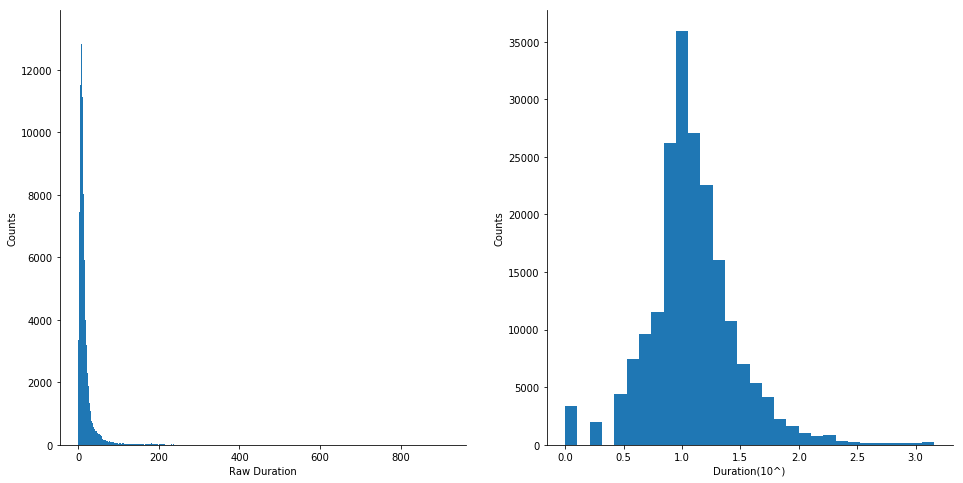

In [18]:
#Trim Trip Duration
# Check trip duration distribution. We can see that the log data is like normal distribution

# Distribution with raw data
plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
labels, values = zip(*Counter(df.duration).items())
indexes = np.arange(len(labels))
ax1.bar(indexes,values, 1)
plt.xlabel('Raw Duration')
plt.ylabel('Counts')
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')

## Distribution with log data 
interval_log = np.log10(np.array(df.duration))
ax2 = plt.subplot(122)
ax2.hist(interval_log, bins=30)
plt.xlabel('Duration(10^)')
plt.ylabel('Counts')
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')

In [19]:
# Based on the plots, we use logged data to trim trip duration in order to remove some outliers.
duration_mean = np.mean(interval_log)
duration_std = np.std(interval_log)

# Set up upbound and bottom bound. t1 is about 4 hours and t2 is about 2 mins.
t1 = np.mean(interval_log) + 2*np.std(interval_log)
t2 = np.mean(interval_log) - 2*np.std(interval_log)

# Trim raw trips data by t1 and t2
trip = df[(df.duration >= 120) & (df.duration <= 4*3600) ]

Discover Lifecycle Interval
---
Kmeans
--

In [20]:
# Since there is no indicator for a bike's lifecycle, we start from using KMeans to group trips of each bike to try to 
# find lifecycle interval. Using Silhouette coefficient to find the optimal K for a specific bike.
#Discover Lifecycle Interval KM
def timedifference(row):
    """Calculate time difference between each trip of a specific bike.
    """
    startdifference = ((row['start_time']-initialstart)/np.timedelta64(1, 'h'))
    enddifference   = ((row['end_time']-initialend)/np.timedelta64(1, 'h'))
    return pd.Series((startdifference, enddifference))

def sil_cal_elbow(X, start, end):
    """Calculate silhouette coeff with different k.
    """
    result_list = []
    for n in range(start, end+1):
        kmeans = KMeans(n_clusters=n)
        p = kmeans.fit(X)
        t = metrics.silhouette_score(X, p.labels_)
        result_list.append(t)
    return result_list

def generatetraining(choose_id):
    """Generate subset based on bike id.
    """
    global initialstart
    global initialend
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    
    test = df[df.bike_id == choose_id]
    
    test = test.sort_values('start_time')
    test['start_time']=pd.to_datetime(test['start_time'].values)
    test['end_time']=pd.to_datetime(test['end_time'].values)
    initialstart = test.iloc[0].start_time
    initialend   = test.iloc[0].end_time
    training_feature  = test.apply(timedifference, axis=1)
    training_feature.columns = ['start_diff', 'end_diff']
    return training_feature

def siloutteplot(training_feature):
    """Plot siloutte vs K.
    """
    t = sil_cal_elbow(training_feature, 2, 10)
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    x_axis=list(range(2,11))
    y_axis=t
    ax.plot(x_axis, t, 'b*-')
    plt.xlabel('K')
    plt.ylabel('Coefficient (1 is best, -1 is worst)')
    plt.title('Silhouette coefficient')
    plt.show()

    
def clusterplot(K, training_feature):
    """Plot clutered trips with optimal K.
    """
    km = KMeans(K)
    km.fit(training_feature)
    mu = km.cluster_centers_
    labels = km.labels_
    fig, ax = plt.subplots(figsize = [8,8], facecolor=[0.9,0.9,0.9])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.scatter(training_feature['start_diff'], training_feature['end_diff'], c=labels, alpha=0.4)
    ax.scatter(mu[:,0], mu[:,1], s=300, c=np.unique(labels))
    plt.xlabel('start time')
    plt.ylabel('end time')
    plt.show()

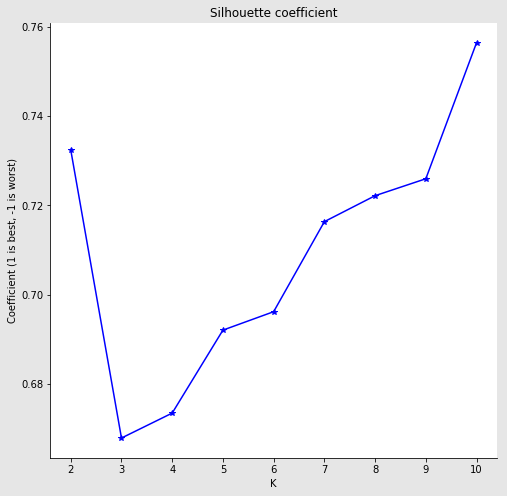

In [21]:
# KMeans with bike_id 2497
#df['bike_id'].value_counts: Series.value_counts of trip_id
#241475855     2497
#241475854    11738
#241475851     3658

training_feature = generatetraining(2497)
siloutteplot(training_feature)

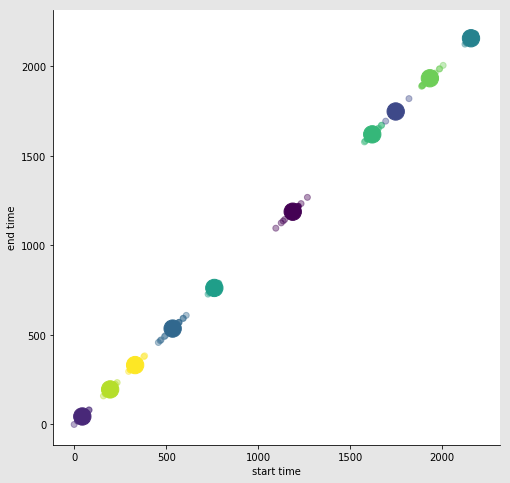

In [22]:
# The optimal K from the above plot is 9. And the clustering for bike id 2497 is pretty good
clusterplot(10, training_feature)

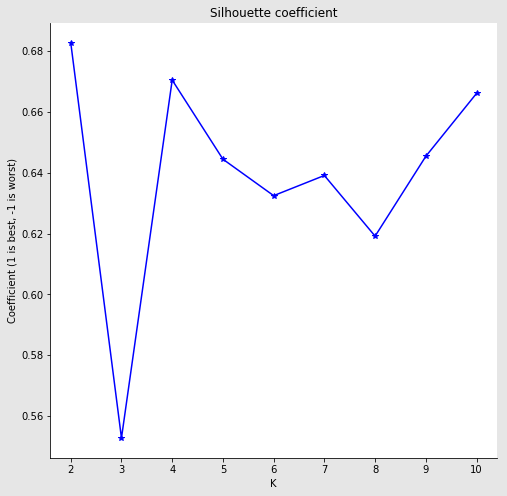

In [23]:
# KMeans with bike_id 3658
training_feature = generatetraining(3658)
siloutteplot(training_feature)

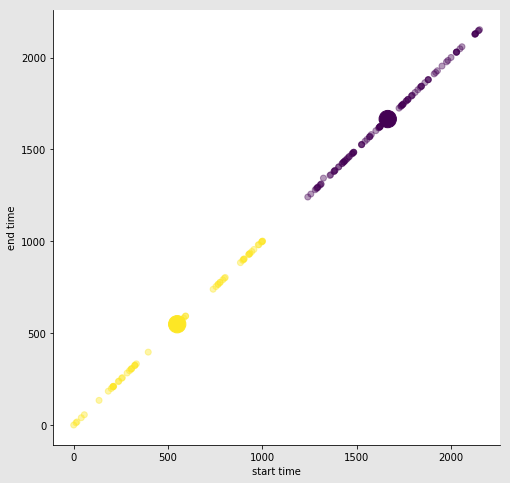

In [24]:
# The optimal K from the above plot is 2. And the clustering for bike id 342 is not that good.
clusterplot(2, training_feature)

From the above two exampels, the method is KMenas fails to find the duration interval for all bikes. With the statistical method to get a reasonal duration interval based on the assumption that duration interval is normal distribution.


In [25]:
#Probability Value
def collectinterval(dataset):
    """Collect all trip intervals.
    """
    interval_list = []
    bikeid = set(dataset.bike_id.unique())
    for bike_id in bikeid:
        temp = dataset[dataset['bike_id'] == bike_id] 
        temp.loc[:,'start_time'] =pd.to_datetime(temp['start_time'].values)
        temp.loc[:,'end_time'] =pd.to_datetime(temp['end_time'].values)
        temp = temp.sort_values(by=['start_time'])
        for i in range(1, len(temp)):
            t = int((temp.iloc[i].start_time-temp.iloc[i-1].end_time)/np.timedelta64(1, 'm'))
            interval_list.append(t)
    return interval_list
interval_list = collectinterval(trip)

/Users/melike/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


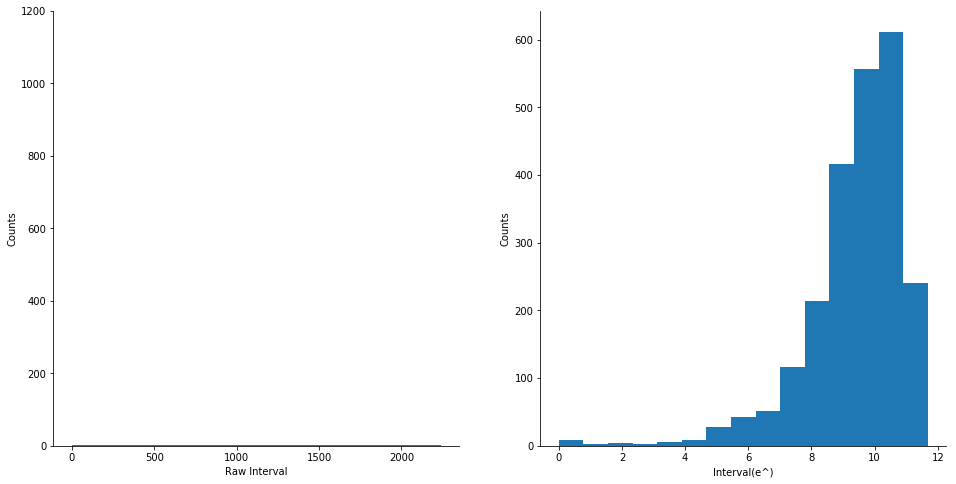

In [27]:
# Distribution with raw data
plt.figure(figsize=(16, 8))
ax3 = plt.subplot(121)
labels, values = zip(*Counter(interval_list).items())
indexes = np.arange(len(labels))
ax3.bar(indexes,values, 1)
plt.xlabel('Raw Interval')
plt.ylabel('Counts')
ax3.set_ylim(0, 1200)
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')

## Distribution with log data 
interval_lg = np.log(np.array(interval_list))
interval_lg = interval_lg[~np.isnan(interval_lg)]
interval_lg = interval_lg[~np.isinf(interval_lg)]
ax4 = plt.subplot(122)
ax4.hist(interval_lg, bins=15)
plt.xlabel('Interval(e^)')
plt.ylabel('Counts')
ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')

In [30]:
# Calculate the up bound of interval. We get t ~= 7 and t2 ~= 4
t = np.mean(interval_lg) + 2*np.std(interval_lg)  # 95%
t2 = np.mean(interval_lg) + (1.644)*np.std(interval_lg) # 90%
print('t: and t2:', t, t2)

('t: and t2:', 12.492744131340508, 11.944808727885562)


In [ ]:
def tempcovert(temp):
    """Group trips with the calculated interval
    """
    final_id_list = []
    bike_group = []
    counts = 0
    final_id = []
    for i in range(len(temp)):
        old_id = temp.iloc[i].bike_id
        if i == 0:
            bike_group.append(str(old_id) +'_'+str(counts))
        elif i == len(temp)-1:
            bike_group.append(str(old_id) +'_'+str(counts)) 
            final_id = str(old_id) +'_'+str(counts) 
            final_id_list.append(final_id)
        else:
            if (int((temp.iloc[i].start_time-temp.iloc[i-1].end_time)/np.timedelta64(1, 'D')) > 4 and
               temp.iloc[i].start_station != temp.iloc[i-1].end_station):
                counts += 1
            elif int((temp.iloc[i].start_time-temp.iloc[i-1].end_time)/np.timedelta64(1, 'D')) > 7:
                counts += 1
            bike_group.append(str(old_id) +'_'+str(counts))
    result = pd.DataFrame(bike_group, columns = ['bike_group'], index=temp.index)
    temp = pd.concat([temp, result], axis =1)
    return temp, final_id

def generateduration(dataset):
    """Generate new dataset based on lifecycle.
    """
    new_pd = pd.DataFrame()
    finalid_list = []
    id_set = set(dataset.bike_id.unique())
    df['counts'] = df['duration'].value_counts()
    for bikeid in id_set:
        temp = dataset[dataset['bike_id'] == bikeid]
        temp.sort_values(by=['start_time'])
        temp['start_time'] =pd.to_datetime(temp['start_time'].values)
        temp['end_time'] =pd.to_datetime(temp['end_time'].values)
        temp, final_id = tempcovert(temp)
        new_pd = pd.concat([new_pd, temp])
        finalid_list.append(final_id)
    return new_pd, finalid_list

new_pd, finalid_list = generateduration(df)
new_pd_removelast = new_pd[~new_pd['bike_group'].isin(finalid_list)]
new_pd_removelast.to_csv('Dataset/lifecycle_final.csv')

/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/melike/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Data Analysis
---
Current Feature Analysis
--
Duration VS Subscription Ratio
-

Duration VS Trips Number
--

In [ ]:
#df = pd.read_csv('indego-trips-2018-q2.csv')


In [4]:
# Load raw data
path =r'/Users/melike/machinelearning/Indeco_data'
allFiles = glob.glob(path + "/*.csv")
list_ = []

for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,parse_dates=['start_time'])
    
    #handle missing column
    df = df.replace('[]', np.nan)
    df = df.replace('...', np.nan)
    #df.replace('',-99999, inplace=True)
    modifiedFlights=df.fillna("...")
    modifiedFlights = df.dropna()
    modifiedFlights.isnull().sum()
    modifiedFlights.to_csv('modifiedFlights.csv',index=False)
    df=df.dropna()
    list_.append(df)
    #df.drop(to_drop, inplace=True, axis=1)
    
    
    
frame = pd.concat(list_)

/Users/melike/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
#df.head()
#df.shape

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,4614547,1620,2016-04-01 00:03:00,4/1/2016 0:30,3023,39.95048,-75.17286,3023,39.95048,-75.17286,3509,30,Round Trip,Indego30
1,4614548,780,2016-04-01 00:06:00,4/1/2016 0:19,3009,39.95576,-75.18982,3066,39.94561,-75.17348,2566,30,One Way,Indego30
2,4614549,60,2016-04-01 00:09:00,4/1/2016 0:10,3063,39.94633,-75.16980,3063,39.94633,-75.16980,3281,30,Round Trip,Indego30
3,4614550,360,2016-04-01 00:10:00,4/1/2016 0:16,3063,39.94633,-75.16980,3064,39.93840,-75.17327,3288,30,One Way,Indego30
4,4614551,660,2016-04-01 00:11:00,4/1/2016 0:22,3066,39.94561,-75.17348,3047,39.95071,-75.14921,3404,30,One Way,Indego30


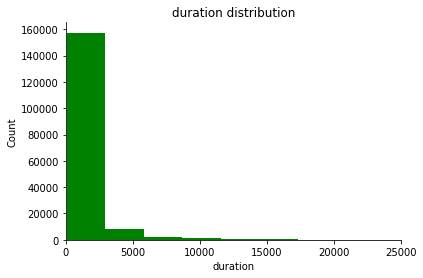

In [142]:
#plt.figure(figsize=(17, 10))
ax6 = plt.subplot(111)
ax6.hist(df['duration'], bins=30, color="green")
plt.xlabel('duration')
plt.ylabel('Count')
plt.title('duration distribution')
ax6.set_xlim(0,25000)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)

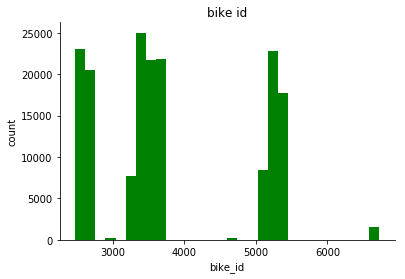

In [143]:
#plt.figure(figsize=(16, 8))
ax2 = plt.subplot(111)
ax2.hist(df['bike_id'], bins=30, color="green")
plt.xlabel('bike_id')
plt.ylabel('count')
plt.title('bike id')
#ax2.set_xlim(0,12000)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

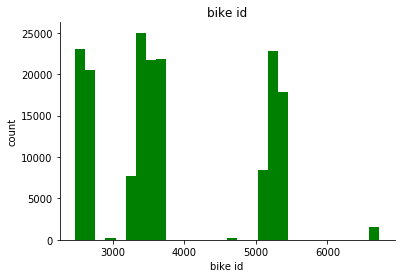

In [144]:
#plt.figure(figsize=(16, 8))
ax2 = plt.subplot(111)
ax2.hist(df['bike_id'], bins=30, color="green")
plt.xlabel('bike id')
plt.ylabel('count')
plt.title('bike id')
#ax2.set_xlim(0,12000)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

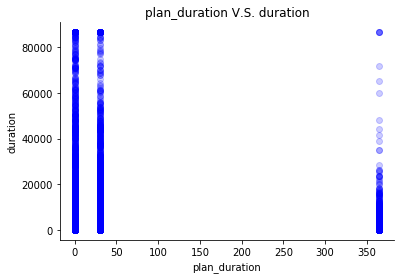

In [145]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
#plt.figure(figsize=(16, 8))
ax7 = plt.subplot(111)
ax7.scatter(df['plan_duration'], df['duration'], color='b', alpha=0.2)
plt.xlabel('plan_duration')
plt.ylabel('duration')
plt.title('plan_duration V.S. duration')
#ax7.set_ylim(0, 20000)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

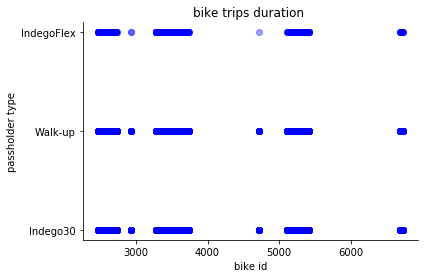

In [146]:

#plt.figure(figsize=(16, 8))
ax77 = plt.subplot(111)
ax77.scatter(df['bike_id'], df['passholder_type'], color='b', alpha=0.2)
plt.xlabel('bike id')
plt.ylabel('passholder type')
plt.title('bike trips duration ')
#ax77.set_ylim(0, 3000)
#ax77.set_xlim(0,12000)
ax77.spines['right'].set_visible(False)
ax77.spines['top'].set_visible(False)

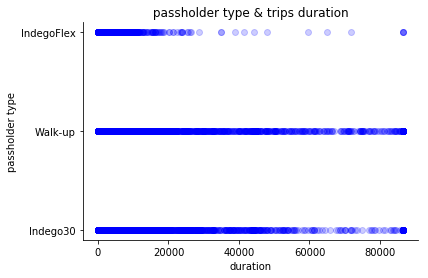

In [147]:
#plt.figure(figsize=(16, 8))
ax87 = plt.subplot(111)
ax87.scatter(df['duration'], df['passholder_type'], color='b', alpha=0.2)
plt.xlabel('duration')
plt.ylabel('passholder type')
plt.title(' passholder type & trips duration ')
#ax77.set_ylim(0, 3000)
#ax77.set_xlim(0,12000)
ax87.spines['right'].set_visible(False)
ax87.spines['top'].set_visible(False)

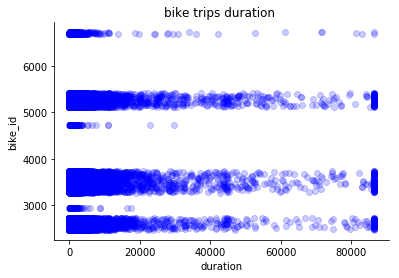

In [105]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
#plt.figure(figsize=(16, 8))
ax7 = plt.subplot(111)
ax7.scatter(df['duration'], df['bike_id'], color='b', alpha=0.2)
plt.xlabel('duration')
plt.ylabel('bike_id')
plt.title('bike trips duration ')
#ax7.set_xlim(0,12000)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

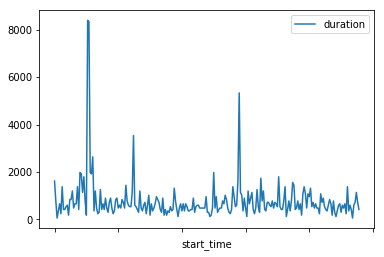

In [148]:
df[:24*10].plot(x='start_time', y='duration')

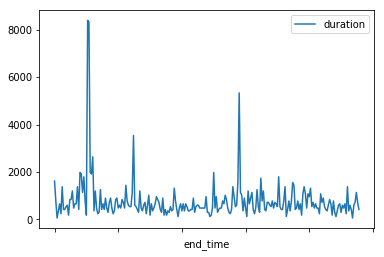

In [149]:
df[:24*10].plot(x='end_time', y='duration')

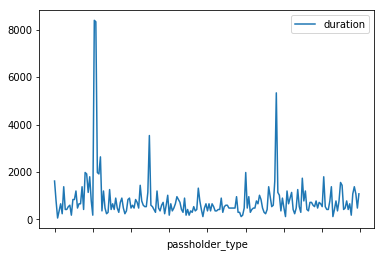

In [108]:
df[:20*10].plot(x='passholder_type', y='duration')

In [151]:
df.sample()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,year,month,hour,counts
98061,4735895,600,2016-05-31 21:02:00,5/31/2016 21:12,3045,39.94792,-75.16237,3034,39.93315,-75.16248,2686,30,One Way,Indego30,2016,5,21,NaN


In [50]:
df.start_lon.head()

1   -75.174072
2   -75.156952
3   -75.166908
4   -75.194794
5   -75.136414
Name: start_lon, dtype: float64

In [152]:
# Heat Map, Check folder 'Html/heatmap.html'
heatMapData = pd.DataFrame()
d = df[['duration', 'start_lat', 'start_lon']].groupby(['start_lat', 'start_lon']).sum()
lats = []
longs = []
for e in d.index.values.tolist():
    lats.append(e[0])
    longs.append(e[1])
heatMapData['start_lat'] = lats
heatMapData['start_lon'] = longs
heatMapData['duration'] = d.duration.values

In [153]:
data = []
for index, row in heatMapData.iterrows():
    temp = {}
    temp['start_lat'] = row['start_lon']
    temp['start_lon'] = row['start_lon']
    temp['count'] = row['duration']
    data.append(temp)

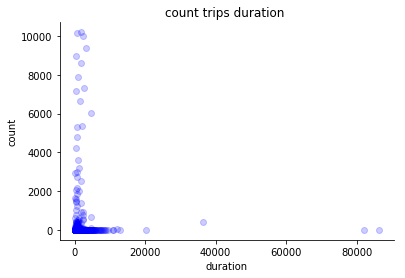

In [154]:
# Second plot: Bike LifeCycle V.S. Trips Number in LifeCycle
#plt.figure(figsize=(16, 8))
ax72 = plt.subplot(111)
ax72.scatter(df['duration'], df['counts'], color='b', alpha=0.2)
plt.xlabel('duration')
plt.ylabel('count')
plt.title('count trips duration ')
#ax72.set_xlim(0,1000)
ax72.spines['right'].set_visible(False)
ax72.spines['top'].set_visible(False)



Duration VS Period
---

In [155]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

times = list(range(8, 21, 4))
labels = ['morning', 'afternoon', 'evening', 'night']
periods = dict(zip(times, labels))
def period(row):
    visit_start = {'hour': row.start_time.hour, 'min': row.start_time.minute} # get hour, min of visit start
    visit_end = {'hour': row.end_time.hour, 'min': row.end_time.minute} # get hour, min of visit end
    for period_start, label in periods.items():
        period_end = period_start + 4
        if period_start <= visit_start['hour'] < period_end:
            if period_start <= visit_end['hour'] < period_end or (period_end - visit_start['hour']) * 60 - visit_start['min'] > (visit_end['hour'] - period_end) * 60 + visit_end['min']:
                return label
            else:
                return periods[period_end] # assign label of following period  
df['period'] = df.apply(period, axis=1)

In [156]:
%matplotlib inline

period = pd.DataFrame()
d = df[['bike_id', 'period', 'duration']].groupby(['bike_id', 'period']).sum()
bike_ids = []
p = []
for e in d.index.values:
    bike_ids.append(e[0])
    p.append(e[1])
period['bike_group'] = bike_ids
period['period'] = p
period['duration'] = [x[0] for x in d.values.tolist()]

# Calculate morning duration rate compared to total duration
morning_duration = pd.merge(duration, period.loc[period.period == 'morning'], on='bike_id', how="left")
morning_duration['period'] = morning_duration['period'].fillna('morning')
morning_duration['duration_y'] = morning_duration['duration_y'].fillna(0)
morning_duration['morning rate'] = morning_duration['duration_y']/morning_duration['duration_x']

# Calculate afternoon duration rate compared to total duration
afternoon_duration = pd.merge(duration, period.loc[period.period == 'afternoon'], on='bike_id', how="left")
afternoon_duration['period'] = afternoon_duration['period'].fillna('afternoon')
afternoon_duration['duration_y'] = afternoon_duration['duration_y'].fillna(0)
afternoon_duration['afternoon rate'] = afternoon_duration['duration_y']/afternoon_duration['duration_x']

# Calculate evening duration rate compared to total duration
evening_duration = pd.merge(duration, period.loc[period.period == 'evening'], on='bike_id', how="left")
evening_duration['period'] = evening_duration['period'].fillna('evening')
evening_duration['duration_y'] = evening_duration['duration_y'].fillna(0)
evening_duration['evening rate'] = evening_duration['duration_y']/evening_duration['duration_x']

# Calculate night duration rate compared to total duration
night_duration = pd.merge(duration, period.loc[period.period == 'night'], on='bike_id', how="left")
night_duration['period'] = night_duration['period'].fillna('night')
night_duration['duration_y'] = night_duration['duration_y'].fillna(0)
night_duration['night rate'] = night_duration['duration_y']/night_duration['duration_x']

plt.figure(figsize=(16, 8))
ax10 = plt.subplot(111)
ax10.scatter(morning_duration['morning rate'], morning_duration['duration_x'], color='blue', alpha=1, label="Morning", s=3)
ax10.scatter(afternoon_duration['afternoon rate'], afternoon_duration['duration_x'], color='red', alpha=1, label="Afternoon", s=3)
ax10.scatter(evening_duration['evening rate'], evening_duration['duration_x'], color='green', alpha=1, label="Evening", s=3)
ax10.scatter(night_duration['night rate'], night_duration['duration_x'], color='orange', alpha=1, label="Night", s=3)

plt.xlabel('Period Ratio')
plt.ylabel('LifeCycle Duration')
plt.title('Bike LifeCycle V.S. Period Ratio')
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
plt.legend()

ValueError: can not merge DataFrame with instance of type <type 'list'>

Modeling
===

In [158]:
df.shape

(170824, 19)

In [164]:
df.head(2)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,year,month,hour,counts,period
0,4614547,1620,2016-04-01 00:03:00,2016-04-01 00:30:00,3023,39.95048,-75.17286,3023,39.95048,-75.17286,3509,30,Round Trip,Indego30,2016,4,0,NaN,None
1,4614548,780,2016-04-01 00:06:00,2016-04-01 00:19:00,3009,39.95576,-75.18982,3066,39.94561,-75.17348,2566,30,One Way,Indego30,2016,4,0,NaN,None


In [15]:
df = df.replace('[]', np.nan)
df = df.replace('...', np.nan)
    #df.replace('',-99999, inplace=True)
modifiedFlights=df.fillna("...")
modifiedFlights = df.dropna()
modifiedFlights.isnull().sum()
modifiedFlights.to_csv('modifiedFlights.csv',index=False)
df=df.dropna()

In [16]:
df.shape

(170824, 14)

In [25]:
df.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type
0,4614547,1620.0,2016-04-01 00:03:00,4/1/2016 0:30,3023.0,39.95048,-75.17286,3023.0,39.95048,-75.17286,3509.0,30.0,Round Trip,Indego30
1,4614548,780.0,2016-04-01 00:06:00,4/1/2016 0:19,3009.0,39.95576,-75.18982,3066.0,39.94561,-75.17348,2566.0,30.0,One Way,Indego30
2,4614549,60.0,2016-04-01 00:09:00,4/1/2016 0:10,3063.0,39.94633,-75.16980,3063.0,39.94633,-75.16980,3281.0,30.0,Round Trip,Indego30
3,4614550,360.0,2016-04-01 00:10:00,4/1/2016 0:16,3063.0,39.94633,-75.16980,3064.0,39.93840,-75.17327,3288.0,30.0,One Way,Indego30
4,4614551,660.0,2016-04-01 00:11:00,4/1/2016 0:22,3066.0,39.94561,-75.17348,3047.0,39.95071,-75.14921,3404.0,30.0,One Way,Indego30


In [20]:
df.start_station= df.start_station.astype(float).fillna(0.0)
df.duration= df.duration.astype(float).fillna(0.0)
df.bike_id= df.bike_id.astype(float).fillna(0.0)
df.plan_duration= df.plan_duration.astype(float).fillna(0.0)
df.end_station= df.end_station.astype(float).fillna(0.0)
# df.drop(['passholder_type'], 1, inplace=True) 
# df.drop(['trip_route_category'], 1, inplace=True)
#df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
#df['end_time'] = pd.to_datetime(df['start_time'], errors='coerce')

In [26]:
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['start_time'], errors='coerce')
to_drop = ['passholder_type',
           'trip_route_category',
            'start_time',
            'end_time',
           'trip_id'
           
            ]
df.drop(to_drop, inplace=True, axis=1)

Linear Regression
==

Fitting Model
--

In [27]:
df.reset_index(drop=True, inplace=True)
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [28]:
rmse_ratio_train = []
rmse_ratio_test = []
error_ratio_train = []
error_ratio_test = []
row_name = []
# shuffle and generate index for training/test
np.random.seed(seed=13579)
#print(int(len(df) * .8))
#train_idx = np.random.choice(range(len(df)), int(len(df) * .8), replace=False)
train_idx = np.random.choice(range(len(df)), 159880, replace=False)
test_idx = list(set(range(len(df))) - set(list(train_idx)))
#print('test_idx', test_idx)

# generate training/test
bdata_train = df.loc[train_idx]
bdata_test = df.loc[test_idx]
bdata_train.reset_index(drop=True, inplace=True)
bdata_test.reset_index(drop=True, inplace=True)

# remove unnecessary columns
train_feature = bdata_train.drop(['duration','bike_id'], axis=1)
test_feature = bdata_test.drop(['duration', 'bike_id'], axis=1)
train_target = bdata_train['duration']
test_target = bdata_test['duration']

train_feature = standardize(train_feature)
test_feature = standardize(test_feature)
print('test_featurestndard', test_feature)


('test_featurestndard',        start_station  start_lat  start_lon  end_station    end_lat    end_lon  \
0          -0.298952   0.146273   0.454867     0.128026   0.090649  -0.088957   
1          -0.758363  -0.194893  -0.251471    -1.260883   0.090671  -0.091483   
2          -0.889624   0.127219   1.165512     0.789411   0.088454  -0.090099   
3           0.357350   1.069962  -0.690164    -0.864052   0.093087  -0.090019   
4          -0.922439   0.009262   0.552696     0.293372   0.095396  -0.093551   
5           0.652686  -0.636776  -0.289619     2.079112   0.092850  -0.092291   
6          -0.463028  -0.667626  -0.672936    -0.268806   0.093144  -0.091693   
7           0.554241  -0.571446  -0.063197     0.690203   0.090791  -0.093447   
8          -1.217775   0.284191  -1.294981     0.987826   0.096673  -0.091674   
9           0.816761   0.825883  -1.175618    -0.566429   0.089427  -0.089983   
10          0.849576  -1.649386   1.437464     2.145251   0.095192  -0.088074   
11  

In [29]:
def compute_rmse(predictions, yvalues):
    # compute_rmse
    assert len(predictions) == len(yvalues)
    rmse = np.sqrt(np.sum(np.power(np.subtract(predictions, yvalues),2))/len(yvalues))
    return rmse

def getaccu_lasso(train_feature, train_target):
    # get the validation score for the lasso model
    kf = KFold(10,random_state=2017)
    clf_dict = {}
    valid_accu = []
    for train_index, test_index in kf.split(train_feature):
        X_train, y_train = train_feature.loc[train_index], train_target.loc[train_index].values
        X_test, y_test = train_feature.loc[test_index], train_target.loc[test_index].values
        clf = Lasso()
        clf.fit(X_train, y_train)
        valid_rmse = compute_rmse(clf.predict(X_test),y_test) 
        valid_accu.append(valid_rmse)
        clf_dict[valid_rmse] = clf
    return valid_accu, clf_dict

def caculateratio(clf, feature, target):
    # caculate the error precetange of the deviation of the predicted value to the actual valus
    predict_y = clf.predict(feature)
    compare_predict = pd.concat([target, pd.DataFrame(predict_y)], axis=1)
    compare_predict.columns = ['true', 'predict']
    compare_predict['error_precent'] = (compare_predict.predict - compare_predict.true) / compare_predict.true
    compare_predict['abs_precent'] = np.abs(compare_predict['error_precent'])
    
    return compare_predict




Optimization - with trips count
--

In [ ]:
from sklearn.model_selection import GridSearchCV

model = Lasso()
alpha_list = list(range(1,50))
parameters = {'alpha':alpha_list,'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model, parameters, cv=10)
grid.fit(train_feature, train_target)
print("r2 / variance : ", grid.best_score_)
print(compute_rmse(grid.predict(test_feature),test_target))
grid.best_params_


So the best parameters using all features are: {'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [ ]:
#{'alpha': 1, 'copy_X': True, 'fit_intercept': True, 'normalize': False}
model = Lasso(alpha=1, copy_X=True, fit_intercept=True, normalize=False)
model.fit(train_feature, train_target)

In [ ]:
model.coef_[1:]

In [ ]:
rmse_opti_oaf_train = compute_rmse(model.predict(train_feature),train_target)/np.mean(train_target)
rmse_opti_oaf_test =compute_rmse(model.predict(test_feature),test_target)/np.mean(test_target)
row_name.append('original_allfeatures')
rmse_ratio_train.append(rmse_opti_oaf_train)
rmse_ratio_test.append(rmse_opti_oaf_test)

In [ ]:
compare_predict_train_opti_oaf = caculateratio(model, train_feature, train_target)
error_ratio_train.append(compare_predict_train_opti_oaf.abs_precent.median())
compare_predict_test_opti_oaf = caculateratio(model, test_feature, test_target)
error_ratio_test.append(compare_predict_test_opti_oaf.abs_precent.median())

In [ ]:
fig, ax = plt.subplots(figsize = [16,8], facecolor = [0.9,0.9,0.9])
x_pos = np.arange(len(train_feature.columns)-1)
 
plt.bar(x_pos, model.coef_[1:])
plt.xticks(x_pos, train_feature.columns[1:], rotation='vertical', fontsize='14')
plt.ylabel('Coefficient',fontsize='14')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

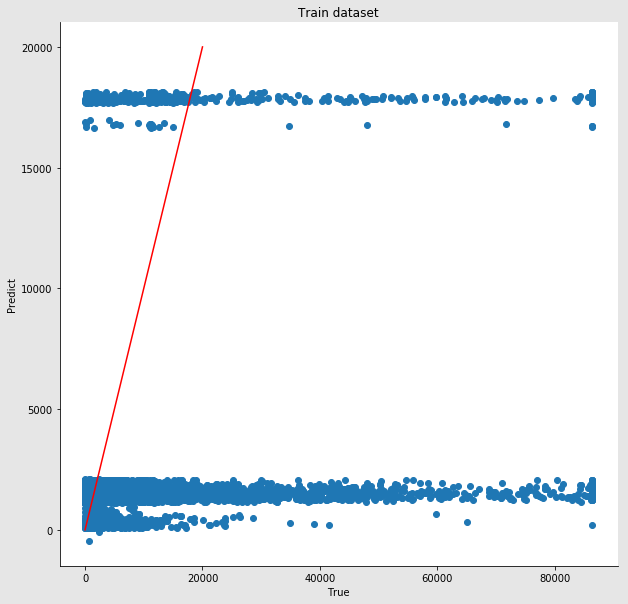

In [45]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_train_opti_oaf.true
y_axis = compare_predict_train_opti_oaf.predict
x_axis2 = range(20000)
y_axis2 = range(20000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

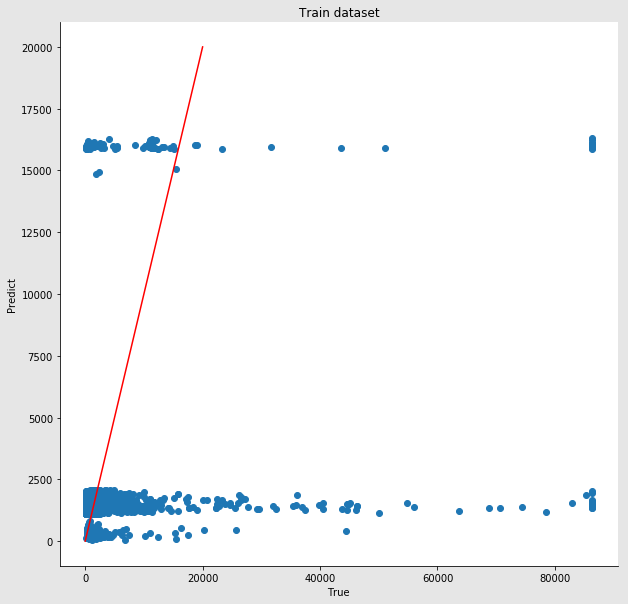

In [46]:
fig, ax = plt.subplots(figsize = [10,10], facecolor = [0.9,0.9,0.9])

x_axis = compare_predict_test_opti_oaf.true
y_axis = compare_predict_test_opti_oaf.predict
x_axis2 = range(20000)
y_axis2 = range(20000)

plt.scatter(x_axis, y_axis)
plt.plot(x_axis2, y_axis2, 'r')
#plt.xticks(x_pos, train_feature.columns, rotation='vertical')
#plt.hist(interval_log, bins=30, alpha=0.75)
plt.xlabel('True')
plt.ylabel('Predict')
plt.title('Train dataset')
#plt.axis([0, 10000, 0, 1000000])
#ax.set_xlim([0, 20])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.show()

Optimization - without trips count